# Reinforcement Learning #

## Setup ##

In [1]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")

import matplotlib.animation
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
# SETTING UP DEFAULT SETTING FOR MATPLOTLIB

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [3]:
IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents = True, exist_ok = True)

def save_fig(fig_id, tight_layout = True, fig_extension = "png", resolution = 300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)

In [4]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

In [5]:
%pip install -q -U gym
%pip install -q -U gym[classic_control,box2d,atari,accept-rom-license]

Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 66.1.1).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-39
      creating build/lib.linux-x86_64-cpython-39/Box2D
      copying library/Box2D/Box2D.py -> build/lib.linux-x86_64-cpython-39/Box2D
      copying library/Box2D/__init__.py -> build/lib.linux-x86_64-cpython-39/Box2D
      creating build/lib.linux-x86_64-cpython-39/Box2D/b2
      copying library/Box2D/b2/__init__.py -> build/lib.linux-x86_64-cpython-39/Box2D/b2
      running build_ext
      building 'Box2D._Box2D' extension
      swigging Box2D/Box2D.i to Box2D/Box2D_wrap.cpp
      swig -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library/Box2D -keyword -w51

## Introduction to OpenAI gym ##

In [6]:
import gym
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [7]:
### """ gym.envs.registry """ is a dictionary containing all available environments

obs, info = env.reset(seed = 42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [8]:
info

{}

In [9]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

In [10]:
pip install gym[classic_control]

Note: you may need to restart the kernel to use updated packages.


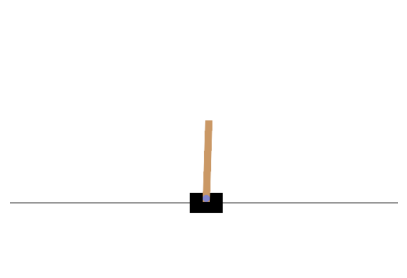

In [11]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [12]:
env.action_space

Discrete(2)

In [13]:
action = 1
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

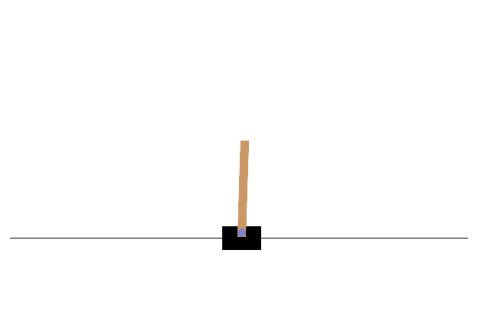

In [14]:
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

In [15]:
reward

1.0

In [16]:
done

False

In [17]:
truncated

False

In [18]:
info

{}

In [19]:
if done or truncated:
    obs, info = env.reset()

## A simple hard-coded policy ##

In [20]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed = episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
    
    totals.append(episode_rewards)


In [21]:
import numpy as np
np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

In [22]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat = False, interval = 40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs = (frames, patch),
        frames = len(frames), repeat = repeat, interval = interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps = 200, seed = 42):
    frames = []
    env = gym.make("CartPole-v1", render_mode = "rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed = seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

## Neural Network Policies ##

In [23]:
import tensorflow as tf

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

In [24]:
def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose = 0)
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

 ### Policy Gradients ###

In [25]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    
    grads = tape.gradient(loss, model.trainable_variables)
    obs, rewards, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

In [26]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    
    return all_rewards, all_grads

            

In [27]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [28]:
discount_rewards([10, 0, -50], discount_factor = 0.8)

array([-22, -40, -50])

In [29]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor = 0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [30]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [31]:
## Create NN and reset the env for reproducibility

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

obs, info = env.reset(seed = 42)

In [32]:
optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [33]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")
    
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis = 0)
        all_mean_grads.append(mean_grads)
        
    
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 183.4

In [34]:
# extra code – displays the animation
np.random.seed(42)
show_one_episode(pg_policy)

# Extra Material - Markov Chains#

In [35]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  
        [0.0, 0.0, 0.9, 0.1],  
        [0.0, 1.0, 0.0, 0.0],  
        [0.0, 0.0, 0.0, 1.0]]

n_max_steps = 1000
terminal_states = [3]

def run_chain(start_state):
    current_state = start_state
    for step in range(n_max_steps):
        print(current_state, end = " ")
        if current_state in terminal_states:
            break
        current_state = np.random.choice(
            range(len(transition_probabilities)),
            p = transition_probabilities[current_state]
        )
    
    else:
        print("...", end = "")
    
    print()
    
for idx in range(10):
    print(f"Run #{idx + 1}: ", end = "")
    run_chain(start_state = 0)

Run #1: 0 0 3 
Run #2: 0 1 2 1 2 1 2 1 2 1 3 
Run #3: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #4: 0 3 
Run #5: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #6: 0 1 3 
Run #7: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #8: 0 0 0 1 2 1 2 1 3 
Run #9: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #10: 0 0 0 1 2 1 3 


## Markov Decision Process ##

In [36]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

## Q-Value Iternation

In [37]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

In [38]:
gamma = 0.90

history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])
        
history1 = np.array(history1)

In [39]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [40]:
Q_values.argmax(axis = 1)

array([0, 0, 1])

## Q-Learning ##

In [41]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [42]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [43]:
Q_values = np.full((3,3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

In [44]:
alpha0 = 0.05
decay = 0.005
gamma = 0.90
state = 0
history2 = []

for iteration in range(10_000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()
    alpha = alpha0/(1 + iteration * decay)
    Q_values[state, action] *= 1- alpha
    Q_values[state, action] += alpha *(reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)

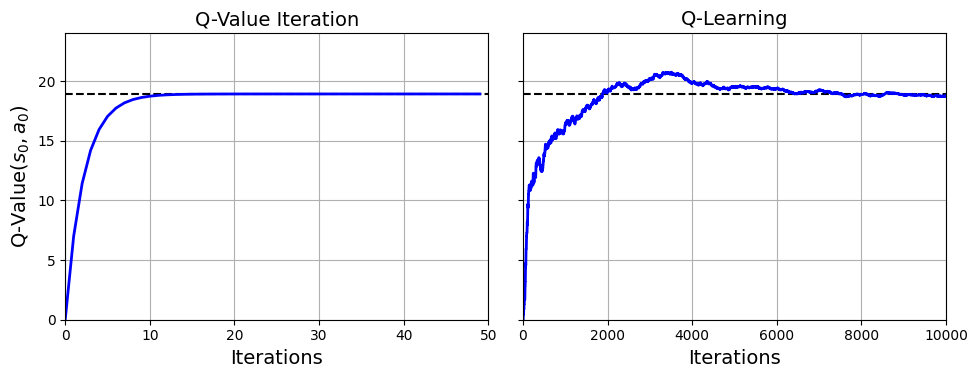

In [45]:
# extra code – this cell generates and saves Figure 18–9

true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

save_fig("q_value_plot")
plt.show()

## Deep Q-Network ##

In [46]:
tf.random.set_seed(42)

input_shape = [4]
n_outputs = 2

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'elu', input_shape = input_shape),
    tf.keras.layers.Dense(32, activation = 'elu'),
    tf.keras.layers.Dense(n_outputs)
])

In [47]:
def epsilon_greedy_policy(state, epsilon = 0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose =0)[0]
        return Q_values.argmax()

In [48]:
from collections import deque

replay_buffer = deque(maxlen = 2000)

In [49]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype = object)
        self.max_size = max_size
        self.index = 0
        self.size = 0
        
    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size
        
    def sample(self, batch_size):
        indices = np.random.randint(self.size, size = batch_size)
        return self.buffer[indices]

In [50]:
def sample_experience(batch_size):
    indices = np.random.randint(len(replay_buffer), size = batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]

In [51]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [52]:
env.reset(seed = 42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

In [53]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate = 1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose = 0)
    max_next_Q_values = next_Q_values.max(axis = 1)
    runs = 1.0  - (dones | truncateds)
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims = True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [54]:
for episodes in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1- episode/500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}", end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 500, Steps: 200, eps: 0.010

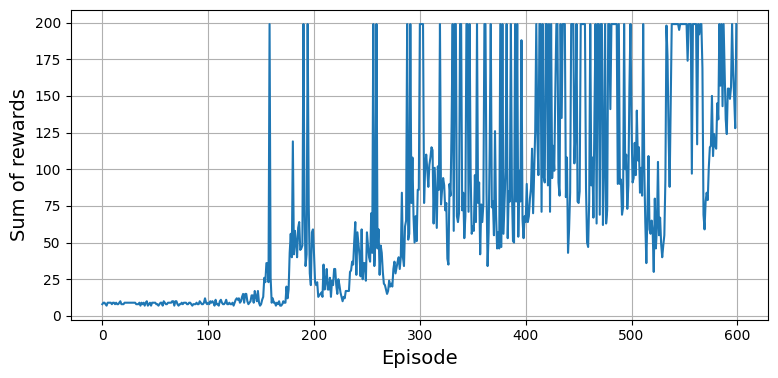

In [55]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
save_fig("dqn_rewards_plot")
plt.show()

In [56]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

## Fixed Q-Value Targets ##

In [57]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'elu', input_shape = input_shape),
    tf.keras.layers.Dense(32, activation = 'elu'),
    tf.keras.layers.Dense(n_outputs)
])

In [58]:
target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [60]:
env.reset(seed = 42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate = 1e-2)
loss_fn = tf.keras.losses.mean_squared_error

replay_buffer = deque(maxlen = 2000)

def training_step(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = target.predict(next_states, verbose = 0)
    max_next_Q_values = next_Q_values.max(axis = 1)
    runs = 1.0 - (done | truncateds)
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims = True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [61]:
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:                        # <= CHANGED
            target.set_weights(model.get_weights())  # <= CHANGED

    # Alternatively, you can do soft updates at each step:
    #if episode > 50:
        #training_step(batch_size)
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index, online_weight in enumerate(online_weights):
        #    target_weights[index] = (0.99 * target_weights[index]
        #                             + 0.01 * online_weight)
        #target.set_weights(target_weights)

model.set_weights(best_weights)  # extra code – restores the best model weights

Episode: 600, Steps: 10, eps: 0.010

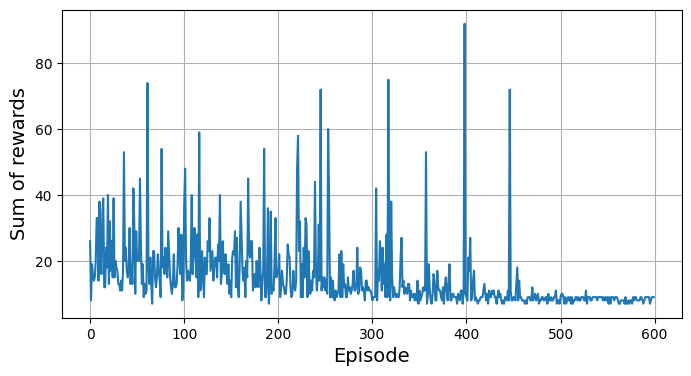

In [62]:
# extra code – this cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [63]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

## Double DQN ##

In [65]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    #################### CHANGED SECTION ####################
    next_Q_values = model.predict(next_states, verbose=0)  # ≠ target.predict()
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask
                        ).sum(axis=1)
    #########################################################

    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

replay_buffer = deque(maxlen=2000)

for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 600, Steps: 200, eps: 0.010

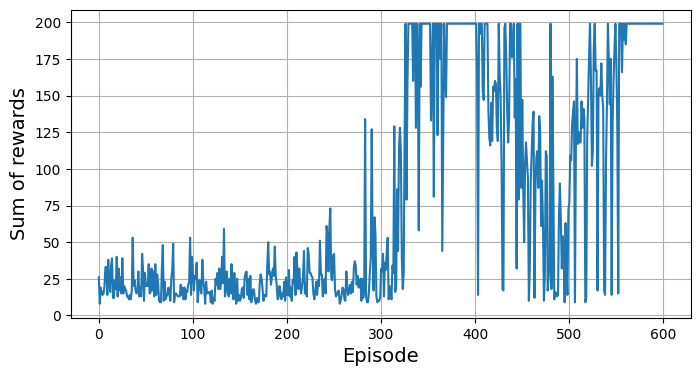

In [66]:
# extra code – this cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [67]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

## Dueling Double DQN ##

In [68]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_states = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = tf.keras.layers.Dense(32, activation="elu")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1,
                                            keepdims=True)
Q_values = state_values + advantages
model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])

In [69]:
# extra code – trains the model

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-3)
loss_fn = tf.keras.losses.mean_squared_error

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

env.reset(seed=42)
replay_buffer = deque(maxlen=2000)
rewards = []
best_score = 0

for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 600, Steps: 190, eps: 0.010

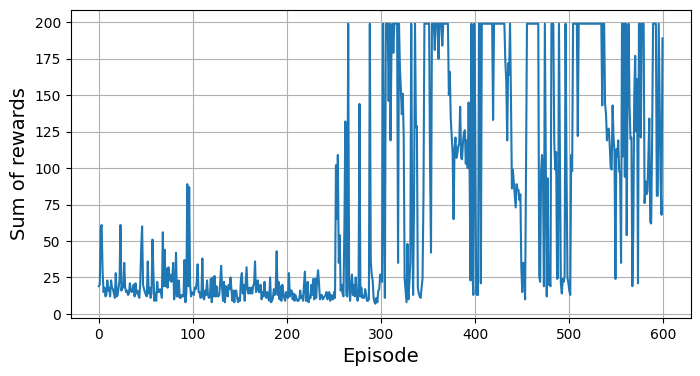

In [70]:
# extra code – this cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [71]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

In [72]:
env.close()